<a href="https://colab.research.google.com/github/PradHolla/Crop-Disease-Detection/blob/master/training/Pepper_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [83]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Pepper",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [84]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [85]:
len(dataset)

78

In [ ]:
68*32

2176

(32, 256, 256, 3)
[0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1]


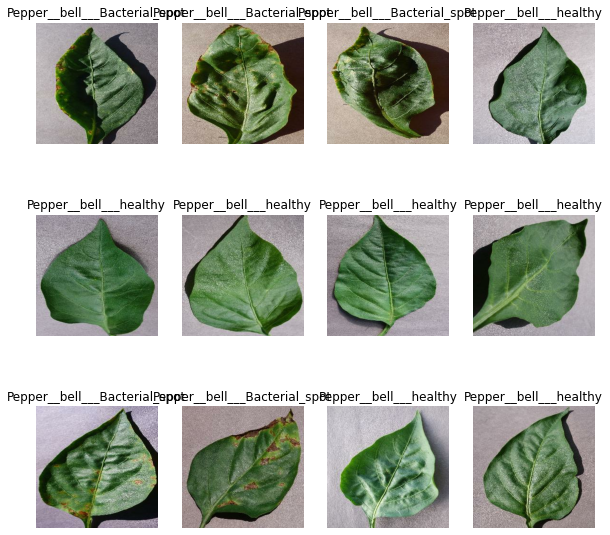

In [86]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

    print(image_batch.shape)
    print(label_batch.numpy())

In [87]:
len(dataset)

78

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [88]:
train_size = 0.8
len(dataset)*train_size


62.400000000000006

In [89]:
train_ds = dataset.take(62)
len(train_ds)

62

In [93]:
test_ds = dataset.skip(62) 
len(test_ds)

16

In [13]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [94]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [95]:
test_ds = test_ds.skip(6)
len(test_ds)

10

In [96]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [97]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [98]:
len(train_ds)

62

In [99]:
len(val_ds)

7

In [100]:
len(test_ds)

9

In [101]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [103]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [109]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [110]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)        

In [111]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [112]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=10,
)

Epoch 1/10
62/62 - 9s - loss: 0.8543 - accuracy: 0.7336 - val_loss: 0.5938 - val_accuracy: 0.7545 - 9s/epoch - 143ms/step
Epoch 2/10
62/62 - 7s - loss: 0.2697 - accuracy: 0.9063 - val_loss: 0.1058 - val_accuracy: 0.9598 - 7s/epoch - 121ms/step
Epoch 3/10
62/62 - 8s - loss: 0.1286 - accuracy: 0.9531 - val_loss: 0.0722 - val_accuracy: 0.9777 - 8s/epoch - 122ms/step
Epoch 4/10
62/62 - 7s - loss: 0.0598 - accuracy: 0.9791 - val_loss: 0.0308 - val_accuracy: 0.9911 - 7s/epoch - 121ms/step
Epoch 5/10
62/62 - 7s - loss: 0.0709 - accuracy: 0.9801 - val_loss: 0.2182 - val_accuracy: 0.9375 - 7s/epoch - 120ms/step
Epoch 6/10
62/62 - 8s - loss: 0.0602 - accuracy: 0.9817 - val_loss: 0.0069 - val_accuracy: 1.0000 - 8s/epoch - 121ms/step
Epoch 7/10
62/62 - 7s - loss: 0.0491 - accuracy: 0.9873 - val_loss: 0.0131 - val_accuracy: 0.9955 - 7s/epoch - 120ms/step
Epoch 8/10
62/62 - 8s - loss: 0.0476 - accuracy: 0.9888 - val_loss: 0.0071 - val_accuracy: 1.0000 - 8s/epoch - 122ms/step
Epoch 9/10
62/62 - 7s - 

In [113]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 1s 62ms/step - loss: 0.0048 - accuracy: 1.0000


In [114]:
scores

[0.004821004346013069, 1.0]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5]

[2.0808749198913574,
 0.6810778975486755,
 0.45522573590278625,
 0.4840245842933655,
 0.26640748977661133]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

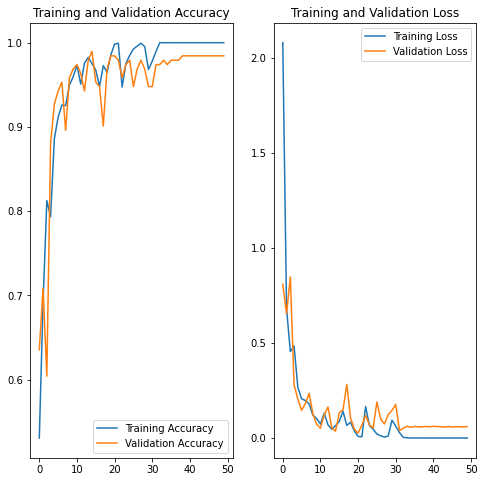

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___Bacterial_spot
predicted label: Pepper__bell___Bacterial_spot


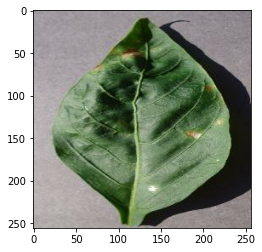

In [115]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [116]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

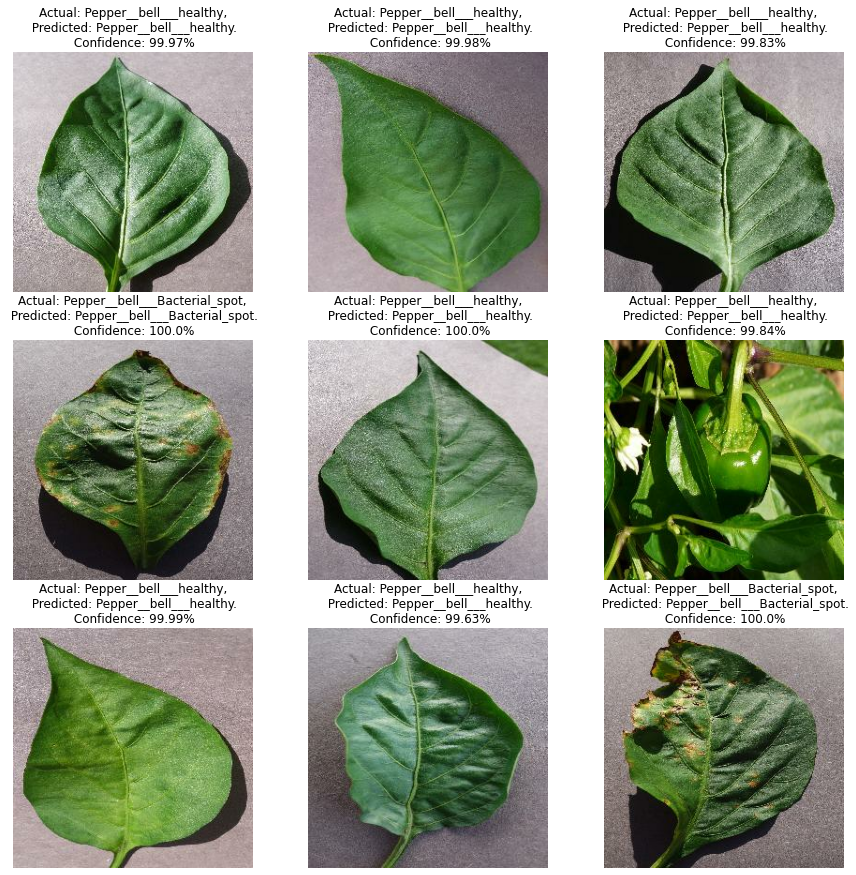

In [117]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


In [118]:
model.save("pepper.h5")

In [119]:
model.save("/content/drive/MyDrive/pepper.h5")